# Distributional assumption test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


In [2]:
from mixedvines.copula import Copula, GaussianCopula, ClaytonCopula, \
        FrankCopula
from mixedvines.mixedvine import MixedVine

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.warn('ignore')

/home/mkim7/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: ignore
  


In [16]:
%matplotlib inline

In [6]:
import sys
sys.path.append('/home/mkim7/Github/scrna-parameter-estimation/scmemo')
import scmemo, utils

In [7]:
data_path = '/data/parameter_estimation/interferon_data/20200324/'

### Useful functions

In [8]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

def convert_var_to_theta(mu, res_var):
    """
    Convert mu, residual variance into mu and theta, assuming alpha=1
    """
    
    var = mu*res_var
    theta = (mu**2)/(var - mu)
    
    return theta

In [9]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    sns.distplot(x[condition], **kwargs)

### Define some parameters

In [25]:
# Noise parameters
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)

In [26]:
# Negative binomial parameters
nb_mean_1 = 3
nb_mean_2 = 3.5
nb_res_var_1 = 2
nb_res_var_2 = 3
nb_theta_1 = convert_var_to_theta(nb_mean_1, nb_res_var_1)
nb_theta_2 = convert_var_to_theta(nb_mean_2, nb_res_var_2)
corr_1 = 0.
corr_2 = 0.3

In [27]:
print(nb_theta_1, nb_theta_2)

3.0 1.75


In [28]:
# Gene A, differential expression
A_mean_ctrl = nb_mean_1
A_mean_stim = nb_mean_2
A_theta_ctrl = nb_theta_1
A_theta_stim = nb_theta_1

# Gene B, differential variability
B_mean_ctrl = nb_mean_1
B_mean_stim = nb_mean_1
B_theta_ctrl = nb_theta_1
B_theta_stim = nb_theta_2

# Correlations
corr_ctrl = corr_1
corr_stim = corr_2

### Simulation functions

In [47]:
def simulate_correlated_data(
    corr,
    mean_1,
    mean_2,
    theta_1,
    theta_2,
    size=1000):
    
    dim = 2  # Dimension
    vine = MixedVine(dim)

    vine.set_marginal(0, stats.nbinom(*convert_params(mean_1, theta_1)))
    vine.set_marginal(1, stats.nbinom(*convert_params(mean_2, theta_2)))
    vine.set_copula(1, 0, GaussianCopula(corr))
    samples = vine.rvs(size)
    
    return samples.astype(int)

def simulate_dropout(
    true_counts,
    q,
    q_sq):
    """ 
        :true_counts: True counts
        :q: first moment of the dropout probability
        :q_sq: second moment of the dropout probability

        Simulate the beta-binomial dropout, an approximation to the hypergeometric 
        for stimulation with few genes.
    """

    m = q
    v = q_sq - q**2
    alpha = m*(m*(1-m)/v - 1)
    beta = (1-m)*(m*(1-m)/v - 1)
    qs = stats.beta.rvs(alpha, beta, size=true_counts.shape[0])

    return stats.binom.rvs(true_counts, np.vstack([qs for i in range(true_counts.shape[1])]).T)

def simulate(N):
    
    # control data
    ctrl_samples = simulate_correlated_data(
        corr_ctrl,
        A_mean_ctrl,
        B_mean_ctrl,
        A_theta_ctrl,
        B_theta_ctrl,
        size=N)
    stim_samples = simulate_correlated_data(
        corr_stim,
        A_mean_stim,
        B_mean_stim,
        A_theta_stim,
        B_theta_stim,
        size=N)
    
    ctrl_obs = simulate_dropout(ctrl_samples, q=p, q_sq=p_sq)
    stim_obs = simulate_dropout(stim_samples, q=p, q_sq=p_sq)
    
    obs_df = pd.DataFrame()
    obs_df['group'] = ['ctrl' for i in range(N)] + ['stim' for i in range(N)]
    obs_df['n_counts'] = 1e5 # A large number for n_counts
    obs_df.index = obs_df.index.astype(str)
    
    adata = sc.AnnData(
        np.vstack([ctrl_obs, stim_obs]), 
        var=pd.DataFrame(index=['gene_A', 'gene_B']),
        obs=obs_df)
    
    return adata

def hypothesis_test(adata, ci=False):
    
    estimator = scmemo.SingleCellEstimator(
        adata=adata, 
        group_label='group',
        n_umis_column='n_counts',
        num_permute=100000,
        beta=p)
    estimator.beta_sq = p_sq
    
    estimator.compute_observed_moments()   
    estimator.mean_var_slope = 1
    estimator.mean_var_inter = 0
    estimator.estimate_1d_parameters()
    estimator.estimate_2d_parameters(
        gene_list_1=['gene_A'],
        gene_list_2=['gene_B'])


    if ci:
        return estimator.compute_confidence_intervals_1d(
        groups=['ctrl','stim'],
        groups_to_compare=[('ctrl', 'stim')])
    
    estimator.compute_confidence_intervals_2d(
        gene_list_1=['gene_A'],
        gene_list_2=['gene_B'],
        groups=['ctrl','stim'],
        groups_to_compare=[('ctrl', 'stim')])
    
    detected_de = estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['de_pval'][0] < 0.05
    detected_dv = estimator.hypothesis_test_result_1d[('ctrl', 'stim')]['dv_pval'][1] < 0.05
    detected_dc = estimator.hypothesis_test_result_2d[('ctrl', 'stim')]['dcorr_pval'][0][0] < 0.05
    
    return detected_de, detected_dv, detected_dc
    
    

### Compute power

In [48]:
imp.reload(scmemo)


<module 'scmemo' from '/home/mkim7/Github/scrna-parameter-estimation/scmemo/scmemo.py'>

In [14]:
Ns = np.logspace(2, 5, 25)
num_trials = 500

In [307]:
de_power = []
dv_power = []
dc_power = []

de_ci = []
dv_ci = []
dc_ci = []

for idx, N in enumerate(Ns):
    
    if idx > 0 and idx % 4 == 0:
    
        with open('de_power_{}.pkl'.format(idx), 'wb') as f:
            pkl.dump(de_power, f)
        with open('dv_power_{}.pkl'.format(idx), 'wb') as f:
            pkl.dump(dv_power, f)
        with open('dc_power_{}.pkl'.format(idx), 'wb') as f:
            pkl.dump(dc_power, f)
    
    de_success = np.zeros(num_trials)
    dv_success = np.zeros(num_trials)
    dc_success = np.zeros(num_trials)
    
    ci_dict_list = []
    
    for trial in range(num_trials):
        adata = simulate(int(N))
        de_success[trial], dv_success[trial], dc_success[trial] = hypothesis_test(adata)

    de_power.append(np.nanmean(de_success))
    dv_power.append(np.nanmean(dv_success))
    dc_power.append(np.nanmean(dc_success))

In [308]:
# with open('de_power_all.pkl', 'wb') as f:
#     pkl.dump(de_power, f)
# with open('dv_power_all.pkl', 'wb') as f:
#     pkl.dump(dv_power, f)
# with open('dc_power_all.pkl', 'wb') as f:
#     pkl.dump(dc_power, f)

In [11]:
with open('de_power_all.pkl', 'rb') as f:
    de_power = pkl.load(f)
with open('dv_power_all.pkl', 'rb') as f:
    dv_power = pkl.load(f)
with open('dc_power_all.pkl', 'rb') as f:
    dc_power = pkl.load(f)

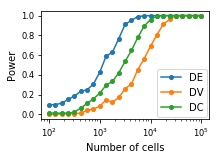

In [20]:
#params = {'legend.fontsize': 9}
pylab.rcParams.update(params)
plt.figure(figsize=(3, 2))
plt.plot(Ns,de_power, 'o-', ms=4)
plt.plot(Ns,dv_power, 'o-', ms=4)
plt.plot(Ns,dc_power, 'o-', ms=4)
plt.xscale('log')
plt.xlabel('Number of cells')
plt.ylabel('Power')
plt.legend(['DE', 'DV', 'DC'], loc='lower right', bbox_to_anchor=(0.52, -0.02, 0.5, 0.5))
plt.savefig('power.pdf', bbox_inches='tight')

### Compute confidence interval - variability

This requires a hack in scmemo.py, returning the full bootstrapped log_mean and log residual var

In [21]:
Ns = [5000, 10000, 50000, 100000]

In [30]:
full_adata = simulate(int(Ns[-1]))

In [46]:
full_adata = simulate(10000)

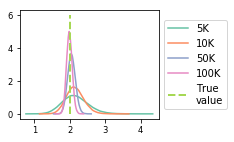

In [70]:
imp.reload(scmemo)
sns.set_palette('Set2')
plt.figure(figsize=(2.5, 2));
#plt.subplots_adjust(wspace=0.3)
full_adata = simulate(int(Ns[-1]))

# plt.subplot(1, 2, 1)
# for N in Ns:

#     adata = full_adata.copy()
#     sc.pp.subsample(adata, n_obs=int(N))
#     mean_boot, res_var_boot = hypothesis_test(adata, ci=True)
#     robust_hist(np.log(mean_boot['ctrl']), hist=False)
# plt.xlim(0.9, 1.2)
# plt.xlabel('Mean\nexpression')
# plt.ylabel('Density')


# plt.subplot(1, 2, 2)
dists = []
for N in Ns:

    adata = full_adata.copy()
    sc.pp.subsample(adata, n_obs=int(N))
    mean_boot, res_var_boot = hypothesis_test(adata, ci=True)
    dists.append(res_var_boot['ctrl'])
    robust_hist(res_var_boot['ctrl'], hist=False, label='{}K'.format(int(N/1000)))
plt.plot([2, 2], [0, 6], '--', label='True\nvalue', lw=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



In [75]:
with open('boot_ci_variability.pkl', 'wb') as f:
    pkl.dump(dists, f)

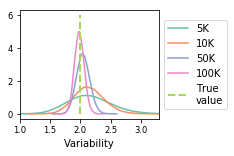

In [74]:
sns.set_palette('Set2')
plt.figure(figsize=(2.5, 2));
for dist, N in zip(dists, Ns):
    robust_hist(dist, hist=False, label='{}K'.format(int(N/1000)))
plt.xlim(1, 3.3)
plt.xlabel('Variability')
plt.plot([2, 2], [0, 6], '--', label='True\nvalue', lw=2)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('ci_numcells_4.pdf', bbox_inches='tight')

### Confidence interval for mean and correlation

To go into supps